<a href="https://colab.research.google.com/github/baligar/real-time-DSP/blob/main/Layer1_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Tier 1: Ultra-Lightweight DSP-Based Indicators (On-Device)**

Goal: Compute simple real-time audio features on the NICLA Voice’s microcontroller or DSP to quickly gauge environment “busyness” with minimal latency and power. These features are derived via basic digital signal processing (DSP) and can run in real time on a microcontroller (Cortex-M4F @ 64 MHz, 64 KB RAM ). They serve as immediate indicators of sound level and complexity:


1. Sound Pressure Level (SPL) Implementation: compute the root-mean-square (RMS) of the audio signal and convert to dB: SPL = 20 * log10(RMS / p_ref) (with p_ref = 20 µPa reference).
2. Root Mean Square (RMS) Amplitude - Essentially the linear version of SPL. RMS gives a quick measure of sound intensity. It can be computed on the fly by accumulating sum(x[i]^2) and taking a square root. This is computationally light (O(N) per window) and memory-light (just need a buffer or running accumulator). A sudden jump in RMS may indicate an abrupt noise or onset of activity.
3. Spectral Centroid – the “center of mass” of the sound’s spectrum, indicating whether the energy is biased towards low or high frequencies. A high spectral centroid means more high-frequency content (e.g. clattering dishes, alarms, or speech fricatives), which could correlate with a busy, information-rich scene. Implementation: perform an FFT on a short window (e.g. 256–512 samples) and compute centroid = (∑_f f * P[f]) / (∑_f P[f]), where $P[f]$ is the power at frequency bin $f$. Using the ARM CMSIS-DSP library on the Cortex-M4F, a 256-pt FFT can be done in a few milliseconds, well within real-time constraints. The NICLA’s NDP120 also contains a HiFi3 audio DSP core, which can offload FFT and filtering tasks.
4. Acoustic Complexity Index (ACI) – a metric originally from ecoacoustics that quantifies variability in sound intensity over time and frequency. Busy natural soundscapes (many birds chirping, etc.) yield high ACI, whereas steady hums or constant noise yield low ACI. In human environments, a high ACI could indicate lots of transient events (speech bursts, music beats, traffic horns) versus a droning constant noise. Implementation: Compute a short-term spectrogram (e.g. 1/8sec frames over a few seconds) and sum the absolute intensity changes in each frequency band, normalized by total energy.



In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

audio_path = '/content/drive/My Drive/Colab Notebooks/audio_samples/Therapist-office_mono_16k.wav'
#audio_path = '/content/drive/My Drive/Colab Notebooks/audio_samples/Busy_Street_Market_mono16k.wav'

y, sr = librosa.load(audio_path, sr=16000)
sams_ = int(45 * sr)
y = y[:sams_]

In [63]:

# Parameters
frame_len, hop_len = 256, 128
p_ref = 20e-6

# RMS and SPL
rms = librosa.feature.rms(y=y, frame_length=frame_len, hop_length=hop_len)[0]
spl = 20 * np.log10(rms / p_ref + 1e-12)

# Spectral Centroid
spectral_centroids = librosa.feature.spectral_centroid(
    y=y, sr=sr, n_fft=frame_len, hop_length=hop_len)[0]

# ACI
S = np.abs(librosa.stft(y, n_fft=frame_len, hop_length=hop_len))
aci = []
for f in range(S.shape[0]):
    band = S[f, :]
    diffs = np.abs(np.diff(band))
    aci_val = np.sum(diffs) / (np.sum(band) + 1e-12)
    aci.append(aci_val)
aci = np.array(aci)

In [64]:
rms[:10], spl[:10]

(array([4.3284628e-05, 9.4716714e-05, 1.2362504e-04, 1.2368387e-04,
        1.7850786e-04, 1.9074439e-04, 1.4868758e-04, 1.9912391e-04,
        2.0944390e-04, 2.1876383e-04], dtype=float32),
 array([ 6.7060747, 13.507934 , 15.821528 , 15.825662 , 19.012547 ,
        19.588436 , 17.424894 , 19.961868 , 20.400753 , 20.778912 ],
       dtype=float32))

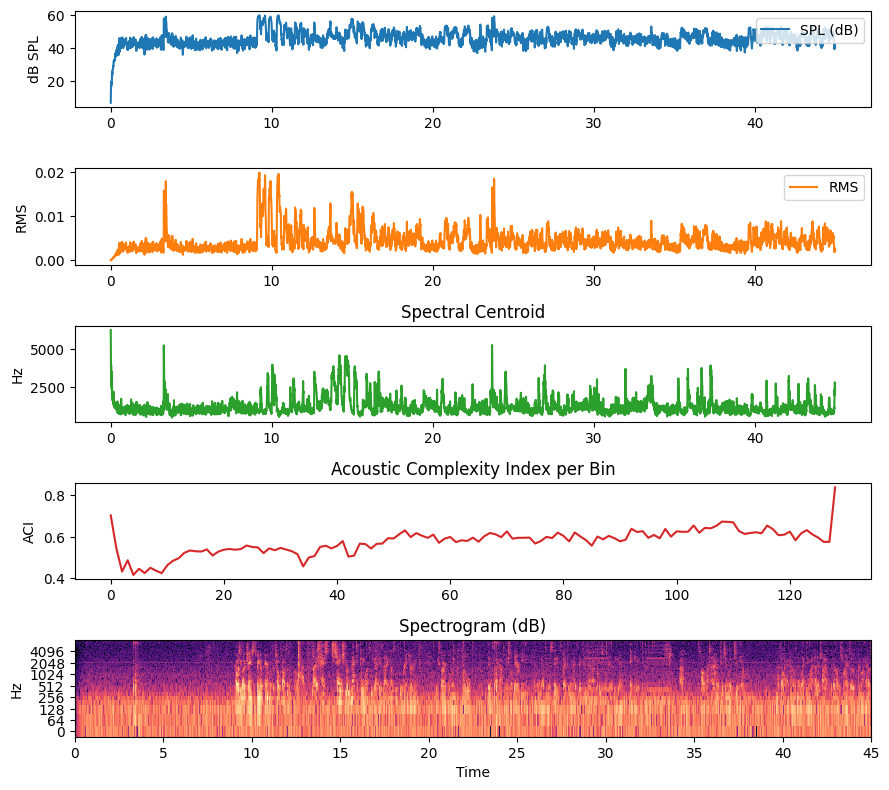

Audio shape: (720000,)


In [65]:
# Time axis
times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_len)

# Plot
plt.figure(figsize=(9, 8))

plt.subplot(5, 1, 1)
plt.plot(times, spl, label='SPL (dB)', color='C0')
plt.ylabel('dB SPL')
plt.legend(loc='upper right')

plt.subplot(5, 1, 2)
plt.plot(times, rms, label='RMS', color='C1')
plt.ylabel('RMS')
plt.legend(loc='upper right')

plt.subplot(5, 1, 3)
plt.plot(times, spectral_centroids, color='C2')
plt.ylabel('Hz')
plt.title('Spectral Centroid')

plt.subplot(5, 1, 4)
plt.plot(aci, color='C3')
plt.ylabel('ACI')
plt.title('Acoustic Complexity Index per Bin')

plt.subplot(5, 1, 5)
librosa.display.specshow(
    librosa.amplitude_to_db(S, ref=np.max),
    sr=sr, hop_length=hop_len, y_axis='log', x_axis='time'
)
#plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')

plt.tight_layout()
plt.show()

print("Audio shape:", y.shape)
ipd.display(ipd.Audio(y, rate=sr))